In [1]:
#| default_exp app_v3

#### Competition

[LINK](https://www.kaggle.com/competitions/playground-series-s3e11/overview)

#### Imports

In [2]:
#| export
from fastai.tabular.all import *

from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


import xgboost as xgb

import seaborn as sns

import optuna

#### Downloading Datasets

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#| export
comp = 'playground-series-s3e11'
path = setup_comp(comp, install='fastai')

In [5]:
# copy .gitignore template from my home directory and append project data folder to it
if not os.path.exists('.gitignore'):
    !cp ~/.gitignore .
if comp not in open('.gitignore').read():
    with open('.gitignore', 'a') as f: f.write(f'{comp}')

#### Create Dataframes

In [6]:
#| export
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_comb = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
#| export
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)
df_comb.drop(['id'], axis=1, inplace=True)

In [8]:
df_train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.20,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [9]:
#| export
df_train['store_sales_per_children'] = df_train['store_sales(in millions)'] / df_train['total_children']

In [10]:
#| export
for column in df_train.columns:
    if (list(df_train[column].unique()) == [0.0, 1.0]):
        df_train.loc[:, column] = df_train[column].astype('bool')

In [11]:
#| export
train_idxs = np.arange(len(df_train))
test_idxs = np.arange(len(df_train), len(df_comb))

In [12]:
dep_var = 'cost'
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(df_comb, max_card=1, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [13]:
df_train = df_comb.iloc[train_idxs]
df_test = df_comb.iloc[test_idxs]

In [14]:
#| export
to_final = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)
test_final = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)
dls_final = to_final.dataloaders(bs=1024)

In [15]:
#| export
fast_train = False
epochs = 14

#### Train Model

In [16]:
#| export
if fast_train == True:
    learn_final = tabular_learner(dls_final, layers=[200, 100], y_range=(0, 150), metrics=rmse)
    learn_final.fit_one_cycle(epochs, 1e-2)
    learn_final.export('models/tab_learner.pkl')


In [17]:
learn_final = load_learner('models/tab_learner.pkl')

In [18]:
#| export
test_dl = learn_final.dls.test_dl(df_test)
preds_final, _ = learn_final.get_preds(dl=test_dl)

#### Get Model Predictions

In [19]:
#| export
preds_final = preds_final.squeeze()

#### Random Forest Model

In [20]:
#| export
xs, y = to_final.train.xs, to_final.train.y
valid_xs, valid_y = to_final.valid.xs, to_final.valid.y
test_xs = test_final.train.xs

In [21]:
#| export
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [22]:
#| export
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

In [23]:
#| export
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [24]:
#| export
m = rf(xs, y, n_estimators=100)

In [25]:
rf_mse = m_rmse(m, valid_xs, valid_y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.175002, 28.227872)

In [26]:
#| export
rf_preds = m.predict(test_xs)

#### Feature Importance

In [27]:
#| export
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False) 

In [28]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
0,store_sales(in millions),0.218168
5,gross_weight,0.205104
8,units_per_case,0.153486
9,store_sqft,0.102240
2,total_children,0.078077
4,avg_cars_at home(approx).1,0.064356
3,num_children_at_home,0.049419
1,unit_sales(in millions),0.034735
6,recyclable_package,0.027331
7,low_fat,0.024042


#### Gradient Boosting

##### Feature Importance

In [29]:
#| export
train_fi = df_train.drop(columns = ['cost'])
target_fi = df_train['cost']

In [30]:
#| export
def plot_fi(data,ax = None,title = None):
    fi = pd.Series(data, index = train_fi.columns).sort_values(ascending = True)
    fi.plot(kind = 'barh', ax = ax)

In [31]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train_fi, target_fi, test_size=0.2)

In [32]:
#| export
fi_params = {'learning_rate': 0.2456172216493356,
 'max_depth': 10,
 'lambda': 0.0023120639864473262,
 'alpha': 0.5848465230832824,
 'colsample_bytree': 0.9966638720347625,
 'min_child_weight': 0,
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [33]:
# fi_params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.05,
#     'max_depth': 6,
#     'min_child_weight': 4,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
# }

In [34]:
#| export
model = xgb.XGBRegressor(**fi_params)


In [35]:
#| export
model.fit(x_train, y_train)

XGBRegressor(alpha=0.5848465230832824, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9966638720347625, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0023120639864473262,
             learning_rate=0.2456172216493356, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

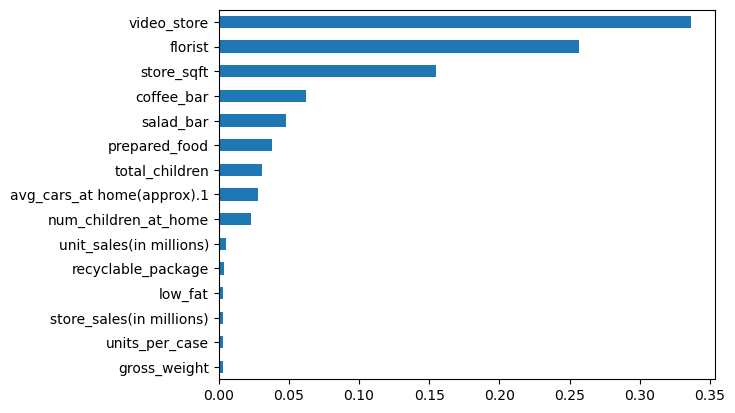

In [36]:
plot_fi(model.feature_importances_)

In [37]:
r = permutation_importance(model, x_test, y_test, n_repeats=1, random_state=46)

<AxesSubplot: >

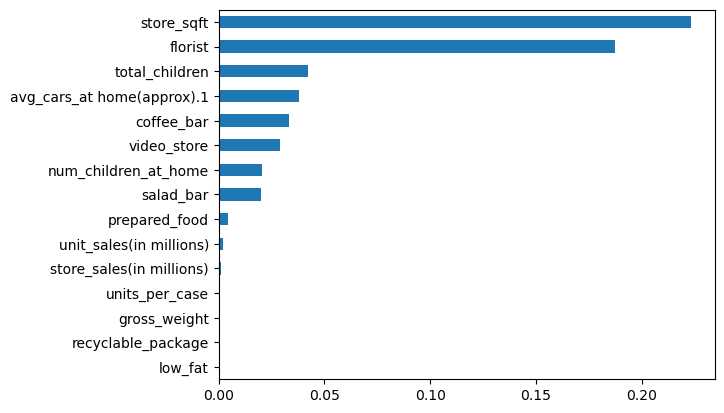

In [38]:
fi = pd.Series(r['importances'].reshape(15,), index = train_fi.columns).sort_values(ascending = True)
fi.plot(kind = 'barh')

In [39]:
# make a list of the features in order of importance
features = list(fi.index)
cols_to_drop = features[0:6]

In [40]:
df_train = df_train.drop(columns=cols_to_drop)

In [41]:
df_train

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...
360331,5.0,5.0,3.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,4.0,0.0,4.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,0.0,0.0,2.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,1.0,0.0,3.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [42]:
df_test = df_test.drop(columns=cols_to_drop)

In [43]:
def fe(data):
    data = data.replace([np.inf, -np.inf], 10)
    return data

In [44]:
train_fe = fe(df_train)
test_fe = fe(df_test)

In [45]:
train = train_fe.drop(columns=['cost'])

In [46]:
train

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,0.0
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
360331,5.0,5.0,3.0,30268.0,0.0,0.0,0.0,0.0,0.0
360332,4.0,0.0,4.0,20319.0,0.0,0.0,0.0,0.0,0.0
360333,0.0,0.0,2.0,30584.0,1.0,1.0,1.0,1.0,1.0
360334,1.0,0.0,3.0,30584.0,1.0,1.0,1.0,1.0,1.0


In [47]:
target = train_fe['cost']

In [48]:
## Searching the best parameter with optuna
x_train, x_test, y_train, y_test = train_test_split(train,target, test_size = 0.2)
d_train = xgb.DMatrix(x_train,y_train)
d_test = xgb.DMatrix(x_test,y_test)


In [49]:
glob_params = {
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle'
}

In [50]:
def objective(trial):
    params = {
        'verbosity':0,
        'n_estimators': trial.suggest_int("n_estimators", 150, 1500),
        'learning_rate': trial.suggest_float('learning_rate',1e-10,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
#        'gamma':trial.suggest_float('gamma',0,8),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',1e-5,1.0),
        'min_child_weight':trial.suggest_int('min_child_weight',0,1),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'grow_policy': trial.suggest_categorical('grow_policy',['depthwise','lossguide']),
#         'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
#         'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
    }
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round = 100,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score


In [51]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 50,)

[I 2023-03-30 19:44:38,831] A new study created in memory with name: no-name-3ecca693-0f69-4490-9bb3-5401cb75aba2
[I 2023-03-30 19:44:39,836] Trial 0 finished with value: 0.3170037467661839 and parameters: {'n_estimators': 1019, 'learning_rate': 0.779979946914882, 'max_depth': 7, 'lambda': 0.5650795118308843, 'alpha': 0.5616068787372499, 'colsample_bytree': 0.03092531955314545, 'min_child_weight': 0, 'booster': 'gblinear', 'sampling_method': 'uniform', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.3170037467661839.
[I 2023-03-30 19:44:40,834] Trial 1 finished with value: 0.3170374994254486 and parameters: {'n_estimators': 1343, 'learning_rate': 0.9221276693117108, 'max_depth': 12, 'lambda': 0.990908006301444, 'alpha': 0.7038041929586502, 'colsample_bytree': 0.2265624795484021, 'min_child_weight': 1, 'booster': 'gblinear', 'sampling_method': 'uniform', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.3170037467661839.
[I 2023-03-30 19:44:43,147] Trial 2 finished w

In [52]:
glob_params

{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmsle'}

In [53]:
best_params = {'n_estimators': 380,
 'learning_rate': 0.9319687783879956,
 'max_depth': 12,
 'lambda': 0.02022953533538882,
 'alpha': 9.277352577569814e-07,
 'colsample_bytree': 0.7477567097593131,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [54]:
best_params.update(study.best_params)
best_params

{'n_estimators': 1349,
 'learning_rate': 0.6686635563248691,
 'max_depth': 10,
 'lambda': 0.05235749466319639,
 'alpha': 0.08040801913836149,
 'colsample_bytree': 0.8330332826656162,
 'min_child_weight': 0,
 'booster': 'dart',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [55]:
df_train

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...
360331,5.0,5.0,3.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,4.0,0.0,4.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,0.0,0.0,2.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,1.0,0.0,3.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [56]:
test_fe

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
360336,1.0,0.0,2.0,20319.0,0.0,0.0,0.0,0.0,0.0,NaN
360337,2.0,2.0,3.0,33858.0,1.0,0.0,1.0,1.0,1.0,NaN
360338,0.0,0.0,3.0,39696.0,0.0,0.0,1.0,1.0,0.0,NaN
360339,3.0,3.0,2.0,23688.0,1.0,1.0,1.0,1.0,1.0,NaN
360340,2.0,0.0,2.0,27694.0,1.0,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
600555,0.0,0.0,1.0,38382.0,0.0,0.0,0.0,0.0,0.0,NaN
600556,2.0,0.0,4.0,30268.0,0.0,0.0,0.0,0.0,0.0,NaN
600557,0.0,0.0,3.0,39696.0,0.0,0.0,1.0,1.0,0.0,NaN
600558,0.0,0.0,2.0,23759.0,1.0,0.0,1.0,1.0,1.0,NaN


In [57]:
# num_folds = 10
# loglosses = []
# final_preds = np.zeros(len(test_fe))
# kf = KFold(n_splits=num_folds, shuffle = True, random_state = 1042)
# for fold, (trn_idx, val_idx) in enumerate(kf.split(train,target)):
#     print('-'*20, 'Fold:', fold + 1, '-'*20)
#     X_train, X_test = train.iloc[trn_idx], train.iloc[val_idx]
#     y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
    
#     d_train = xgb.DMatrix(X_train,y_train)
#     d_test = xgb.DMatrix(X_test,y_test)
    
#     model =  xgb.train(best_params, d_train, num_boost_round = 200,
#                         evals = [(d_test, 'valid')], 
#                         early_stopping_rounds=20, verbose_eval=True
#                        )
# #     preds = model.predict(d_test)
# #     logloss = metrics.log_loss(y_test, preds)
# #     loglosses.append(logloss)
# #     print(f'Logloss: {logloss}')
    
#     preds = model.predict(xgb.DMatrix(test_fe))
#     final_preds += preds / num_folds

In [58]:
df_train

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...
360331,5.0,5.0,3.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,4.0,0.0,4.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,0.0,0.0,2.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,1.0,0.0,3.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [59]:
cont, cat = cont_cat_split(df_train, max_card=1, dep_var='cost')

In [60]:
to = TabularPandas(df_train, procs, cat, cont, y_names='cost', splits=splits)

In [61]:
to_test = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)

In [62]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
test_xs = to_test.xs

In [63]:
gb_train = xgb.DMatrix(xs, label=y)
gb_valid = xgb.DMatrix(valid_xs, label=valid_y)
gb_test = xgb.DMatrix(test_xs)

In [64]:
model =  xgb.train(best_params, gb_train, num_boost_round = 200,
                        evals = [(gb_valid, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=True
                       )

[0]	valid-rmsle:3.73958
[1]	valid-rmsle:3.31784
[2]	valid-rmsle:2.90570
[3]	valid-rmsle:2.50516
[4]	valid-rmsle:2.11894
[5]	valid-rmsle:1.75057
[6]	valid-rmsle:1.40489
[7]	valid-rmsle:1.08876
[8]	valid-rmsle:0.81177
[9]	valid-rmsle:0.58732
[10]	valid-rmsle:0.43017
[11]	valid-rmsle:0.34594
[12]	valid-rmsle:0.31481
[13]	valid-rmsle:0.30701
[14]	valid-rmsle:0.30295
[15]	valid-rmsle:0.30163
[16]	valid-rmsle:0.29948
[17]	valid-rmsle:0.29861
[18]	valid-rmsle:0.29844
[19]	valid-rmsle:0.29799
[20]	valid-rmsle:0.29776
[21]	valid-rmsle:0.29738
[22]	valid-rmsle:0.29686
[23]	valid-rmsle:0.29646
[24]	valid-rmsle:0.29628
[25]	valid-rmsle:0.29614
[26]	valid-rmsle:0.29601
[27]	valid-rmsle:0.29588
[28]	valid-rmsle:0.29578
[29]	valid-rmsle:0.29568
[30]	valid-rmsle:0.29562
[31]	valid-rmsle:0.29555
[32]	valid-rmsle:0.29548
[33]	valid-rmsle:0.29543
[34]	valid-rmsle:0.29533
[35]	valid-rmsle:0.29531
[36]	valid-rmsle:0.29518
[37]	valid-rmsle:0.29515
[38]	valid-rmsle:0.29503
[39]	valid-rmsle:0.29500
[40]	valid

In [65]:
preds = model.predict(xgb.DMatrix(test_xs))


***

In [66]:
xgb_mse = r_mse(model.predict(gb_valid), valid_y)
xgb_mse

28.194116

In [67]:
df_train

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...
360331,5.0,5.0,3.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,4.0,0.0,4.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,0.0,0.0,2.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,1.0,0.0,3.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [68]:
study.best_params

{'n_estimators': 1349,
 'learning_rate': 0.6686635563248691,
 'max_depth': 10,
 'lambda': 0.05235749466319639,
 'alpha': 0.08040801913836149,
 'colsample_bytree': 0.8330332826656162,
 'min_child_weight': 0,
 'booster': 'dart',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise'}

In [69]:
preds, rf_preds, preds_final

(array([ 90.17814 ,  93.906204,  93.6516  , ...,  93.6516  , 105.0644  ,
        107.35126 ], dtype=float32),
 array([103.35292383,  89.56224564, 104.73319488, ...,  98.896543  ,
        120.47056809, 111.05217734]),
 tensor([ 97.8419,  97.0494, 100.4518,  ..., 100.7054, 110.7893, 105.8562]))

In [70]:
#| export
ens_preds = (to_np(preds_final) + rf_preds + preds) / 3

In [71]:
ens_preds

array([ 97.12430937,  93.50593989,  99.61218343, ...,  97.75117158,
       112.10807368, 108.08655036])

In [72]:
#| export
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df['cost'] = ens_preds
sample_df.to_csv('submission.csv', index=False)

In [73]:
!head submission.csv

id,cost
360336,97.12430936806402
360337,93.5059398932184
360338,99.61218343039461
360339,99.4713472220264
360340,80.9961309428299
360341,106.20218617909352
360342,110.73337492915412
360343,94.92941656036108
360344,90.42468342380285


In [74]:
sample_df.max()

id      600559.000000
cost       136.824965
dtype: float64

In [75]:
submit = True

In [76]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='submission.csv', message="drop id column", competition=comp)

100%|██████████| 5.79M/5.79M [00:02<00:00, 2.43MB/s]


In [ ]:
import nbdev
nbdev.export.nb_export('media_campaign_cost_boost.ipynb', 'app_v3')
print("export successful")